In [ ]:
!pip install torch-lr-finder
!pip install torch-summary
!pip install scikit-multilearn


In [ ]:
from torch_lr_finder import LRFinder
from xray.models.resnet50 import Resnet50
import torch 
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from xray.models.dataset import XrayDataset, XrayStratifiedDataset
from xray.models.selected_labels import selected_labels
from xray.construct_labels import generate_test_val_train_datasets, generate_stratified_test_val_train_datasets
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



cuda:0


In [ ]:
trainx, trainy, testx, testy, valx, valy = generate_stratified_test_val_train_datasets("./xray/padchest_img_labels.csv")


train_transform = transforms.Compose([
    #transforms.RandomAdjustSharpness(sharpness_factor=0.75),
    transforms.RandomRotation(degrees=(0,180)),
    transforms.RandomInvert(),
    transforms.ToTensor()
])

testval_transform = transforms.Compose([
    transforms.ToTensor()
])

BATCH_SIZE = 20

train_dataset = XrayStratifiedDataset("./xray/data", trainx, trainy, train_transform)
val_dataset = XrayStratifiedDataset("./xray/data", valx, valy, testval_transform)
test_dataset = XrayStratifiedDataset("./xray/data", testx, testy, testval_transform)

trainloader = DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE)
valloader = DataLoader(dataset=val_dataset, batch_size = BATCH_SIZE)
testloader = DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE)

num_classes = len(selected_labels)

print(len(train_dataset), "train")
print(len(val_dataset), "val")
print(len(test_dataset), "test")
print(num_classes)


Finished  building train, val, and test sets
130461 train
14391 val
15993 test
22


[ 9098.  7258. 12165.  4815. 18855.  3074.  1246.  1994. 16812.  1221.
  3297. 41081.  4311. 20191.  8113.  6621.   432.  1140.  1323.  6433.
 10744.  1063.]
[1011.  806. 1352.  535. 2095.  341.  138.  221. 1868.  136.  366. 4565.
  479. 2243.  902.  736.   48.  127.  147.  715. 1194.  118.]
[1123.  896. 1502.  596. 2328.  379.  154.  246. 2075.  151.  407. 5072.
  600. 2493. 1002.  817.   53.  188.  163.  794. 1326.  131.]
['aortic elongation', 'atelectasis', 'cardiomegaly', 'catheter', 'copd signs', 'pleural effusion', 'electrical device', 'emphysema', 'heart insufficiency', 'infiltrates', 'mass', 'nodule', 'normal', 'nsg tube', 'other findings', 'pneumonia', 'pneumothorax', 'pulmonary edema', 'pulmonary fibrosis', 'surgery', 'thoracic cage deformation', 'tuberculosis']
22
9098.0 aortic elongation
7258.0 atelectasis
12165.0 cardiomegaly
4815.0 catheter
18855.0 copd signs
3074.0 pleural effusion
1246.0 electrical device
1994.0 emphysema
16812.0 heart insufficiency
1221.0 infiltrates
3

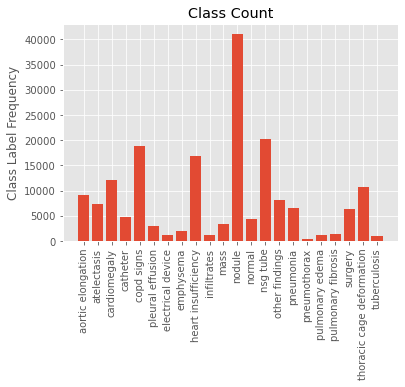

In [ ]:

import numpy as np

lenoflabels = len(selected_labels)
trainvals = np.zeros(lenoflabels)

for label in trainy:
    i = 0
    for val in label:
        trainvals[i] += val
        i += 1

testvals = np.zeros(lenoflabels)

for label in testy:
    i = 0
    for val in label:
        testvals[i] += val
        i += 1

valvals = np.zeros(lenoflabels)

for label in valy:
    i = 0
    for val in label:
        valvals[i] += val
        i += 1
        
print(trainvals)
print(valvals)
print(testvals)
print(selected_labels)
print(len(selected_labels))

for id, x in enumerate(trainvals):
    print(x, selected_labels[id])

import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = selected_labels
energy = trainvals

x_pos = [i for i, _ in enumerate(x)]
print(len(x_pos),
len(x),
len(energy))
plt.bar(x_pos, energy)
plt.ylabel("Class Label Frequency")
plt.xticks(x_pos,x, rotation=90)
plt.title("Class Count")

plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-04


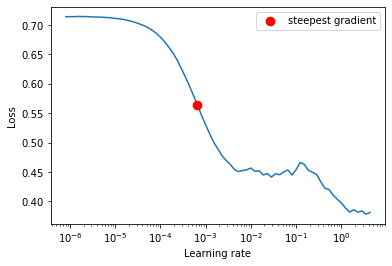

In [ ]:
from torchsummary import summary
resnet_model = Resnet50(num_classes)
resnet_model.to(device)


#use as feature extractor turn in function
for param in resnet_model.parameters():
    param.requires_grad = False

for name, param in resnet_model.named_parameters():
    if "layer4.2.conv3" in name:
        param.requires_grad = True
    if "layer4.2.bn3" in name:
        param.requires_grad = True
    if "fc" in name:
        param.requires_grad = True

params = list(resnet_model.fc.parameters()) + list(resnet_model.layer4[2].bn3.parameters()) + list(resnet_model.layer4[2].conv3.parameters())

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params, lr=1e-7)
lr_finder = LRFinder(resnet_model, optimizer, criterion, device="cuda")


lr_finder.range_test(trainloader, end_lr=100, num_iter=100)

lr_finder.plot()
lr_finder.reset()




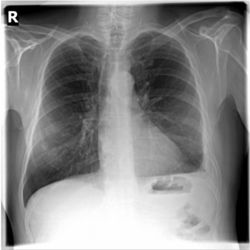

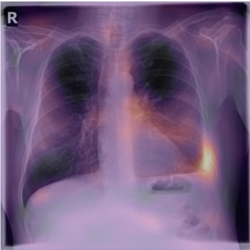

In [3]:
from xray.utils.cam import return_CAM
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
from xray.models.vgg import vgg16
model = VGG16()
model.load_state_dict(torch.load("./savedvgg16model.pth"))

sig = nn.Sigmoid()
img_pil = Image.open("./effusion.png")
img_tensor = trainval_transform(img_pil)
batched_img = img_tensor.unsqueeze(0)
idx = 4
model.eval()
scores = model(img_tensor)
probs = sig(scores)

feature_maps = model.conv(img_tensor)
CAM = return_CAM(feature_maps.detach.numpy(), weight, idx)

heatmap = cv2.applyColorMap(CAMs[0], cv2.COLORMAP_MAGMA)

image = image_tensor.numpy().transpose((1,2,0))
image = image * 255.0
image = np.clip(image, 0,1)

plt.imshow(image)
plt.show()
plt.imshow(0.5 * heatmap + 0.5 * image)
plt.show()

